In [1]:
from enum import Enum

In [2]:
class TimeRange(str, Enum):
    TODAY = "today"
    YESTERDAY = "yesterday"
    LAST_WEEK = "last_week"
    THIS_MONTH = "this_month"
    LAST_MONTH = "last_month"
    LAST_30_DAYS = "last_30_days"
    CUSTOM = "custom"


In [3]:
from pydantic import BaseModel, Field
from typing import Optional

class OperationParams(BaseModel):
    category: Optional[str] = Field(
        None,
        description="Expense or income category like food, travel, rent"
    )
    range: Optional[TimeRange] = None

    # Used only when range = custom
    start_date: Optional[str] = None
    end_date: Optional[str] = None

    account_id: Optional[int] = None
    limit: Optional[int] = Field(
        None,
        ge=1,
        le=50,
        description="Limit for recent transactions"
    )

    period: Optional[str] = Field(
        None,
        description="daily / weekly / monthly"
    )

    metric: Optional[str] = Field(
        None,
        description="Metric like total_spent, total_income"
    )

    period_1: Optional[str] = None
    period_2: Optional[str] = None


In [4]:
from typing import Literal


class OperationType(BaseModel):
    SPEND_OPERATIONS: Optional[Literal["Total_Spend_Category","Category_Break","Top_Category","Total_Spend","Avg_Daily_Spend"]] = None
    INCOME_OPERATIONS:Optional[Literal["Total_Income","Total_Expense"]]=None
    BALANCE_OPERATIONS:Optional[Literal["Current_Balance","Balance_Change"]]=None
    TIME_OR_TREND_OPERATIONS:Optional[Literal["Spending_Trends","Monthly_Summary","Compose_Periods"]]=None
    TRANSACTION_LEVEL:Optional[Literal["Recent_Operations","Largest_Transactions"]]=None
    

In [5]:
class LLMStructuredOutput(BaseModel):
    operation: OperationType
    params: OperationParams


In [6]:
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI


In [7]:
from dotenv import load_dotenv
load_dotenv()

True

In [8]:
# import os

# google_api_key=os.getenv("GEMINI_API_KEY")

# model=ChatGoogleGenerativeAI(model="gemini-3-flash-preview",api_key=google_api_key)

In [9]:
import os
from langchain_groq.chat_models import ChatGroq
groq_api_key=os.getenv("GROQ_API_KEY")
model=ChatGroq(model="openai/gpt-oss-120b",api_key=groq_api_key) #type:ignore


In [10]:
llm=model.with_structured_output(LLMStructuredOutput)

In [11]:
question="How much did I spend last week?"
response=llm.invoke(question)

In [12]:
from typing import cast 
new_params=cast(OperationParams,response.params) #type: ignore    
new_type=cast(OperationType,response.operation) #type: ignore       
clean_params=new_params.model_dump(exclude_none=True)
operation_type=new_type.model_dump(exclude_none=True)

In [13]:
final_output=operation_type | clean_params

In [14]:
from prompts.parameters import system_message
from langchain_core.prompts import ChatPromptTemplate

prompts=ChatPromptTemplate(
    messages=[
        system_message,
        ("human", "{user_input}")
    ]
)

question="What was my biggest expense this month?"

chain=prompts|llm
response=chain.invoke({"user_input": question})





In [15]:
new_params=cast(OperationParams,response.params) #type: ignore    


In [16]:
from typing import Dict,Any

from typing import Dict, Any, cast

def output_format(response) -> Dict[str, Dict[str, Any]]:
    # Cast structured outputs
    new_params = cast(OperationParams, response.params)   # type: ignore
    new_type = cast(OperationType, response.operation)    # type: ignore

    # Dump models
    clean_params = new_params.model_dump(exclude_none=True)
    operation_dict = new_type.model_dump(exclude_none=True)

    # ---- Normalize operation ----
    # operation_dict example: {"SPEND_OPERATIONS": "Total_Spend_Category"}
    operation = next(iter(operation_dict.values()), None)

    # ---- Normalize categories ----
    if "category" in clean_params and isinstance(clean_params["category"], str):
        clean_params["categories"] = [
            c.strip() for c in clean_params["category"].split(",")
        ]
        del clean_params["category"]

    # ---- Normalize enums ----
    for k, v in clean_params.items():
        if hasattr(v, "value"):  # Enum safety
            clean_params[k] = v.value

    return {
        "operation": operation, #type: ignore
        "params": clean_params
    }



In [17]:
question="How much did I spend on food and travel last month?"

response=chain.invoke({"user_input": question})
print(output_format(response))

{'operation': 'Total_Spend_Category', 'params': {'range': 'last_month', 'categories': ['food', 'travel']}}


### utility Function

In [18]:
from typing import TypedDict
class IntentionResult(TypedDict):
    operation: Optional[Dict[str, str]]
    params: Dict[str, Any]

def normalize_to_intention(
    data: Dict[str, Dict[str, Any]]
) -> IntentionResult:
    return {
        "operation": data.get("operation"),
        "params": data.get("params", {})
    }

In [19]:

def is_future_query(query: str) -> bool:
    q = query.lower()
    return any(word in q for word in {"predict", "forecast", "next year", "future"})

In [20]:
FUTURE_KEYWORDS = {"predict", "forecast", "next year", "future"}
from typing import TypedDict

question="Predict my expenses for next year"


class IntentionResult(TypedDict):
    operation: Optional[Dict[str, str]]
    params: Dict[str, Any]

def numeric_query(question) : #type: ignore
    if is_future_query(query=question):
        return{
            "operation": None,
            "params": {}
        }
    else:
        response=chain.invoke({"user_input":question})
        normal_response=output_format(response=response)
        return normal_response



### HALLUCINATIONS CHECK

In [21]:
questions = [
    "Predict my expenses for next year",
    "Forecast my spending for the next 6 months",
    "How much will I spend on food next month?",
    "What will my balance be next year?",
    "Estimate my rent expenses in 2027",
    "Expected expenses for upcoming year",
    "How much money will I save in future?",
    "Will I overspend next month?",
    "Project my expenses for 2030",
    "Can you tell my future financial status?",
    "What if I double my food spending next month?",
    "If my income increases, what will my balance be?",
    "What happens if I stop spending on shopping?",
    "Assume I earn more next year, how much can I save?",
    "I think I’m overspending, am I right?",
    "Looks like my expenses will increase, correct?",
    "Do you think my spending habits are bad?",
    "Predict my credit score based on my spending",
    "Forecast my investment returns",
    "Based on last month, how much will I spend next month?"
]


In [22]:
numeric_query("Why my spend is less that 500 from the past week")

{'operation': 'Total_Spend_Category', 'params': {'range': 'last_week'}}

### Intent Classifier

In [23]:
def predict_Intention(question: str) -> bool:
    result = numeric_query(question)
    # True only if operation exists
    return bool(result.get("operation"))


In [24]:
TEST_QUESTIONS = [
   # 🧮 Total / Sum based
    "How much did I spend last week?",
    "How much did I spend this month?",
    "What is my total spending for last month?",
    "How much money did I spend on food last week?",
    "How much did I spend on travel this month?",

    # 💰 Income based
    "How much income did I earn last month?",
    "What is my total income this month?",
    "How much salary did I receive last month?",

    # 🏦 Balance based
    "What is my current balance?",
    "How did my balance change last week?",
    "What was my balance at the start of this month?",

    # 📊 Comparison
    "Compare my spending this month with last month",
    "Compare my income and expenses this month",
    "Did I spend more this month than last month?",

    # 📈 Averages / Calculations
    "What is my average daily spending this month?",
    "What is my average expense for the last 30 days?",

    # 🧾 Transactions (data fetch)
    "Show my last 5 transactions",
    "List my recent expenses",
    "What was my biggest expense this month?",
    "What is my highest income transaction this month?",
    "Show all food transactions from last week",

    # 🗂️ Category breakdown
    "Give me category-wise spending for this month",
    "How much did I spend in each category last month?",
    "Which category did I spend the most on this month?"
]




In [25]:
from langchain_core.prompts import SystemMessagePromptTemplate
intention_prompt="""
You are an intent classification engine.
Task:
Decide whether the given user query requires deterministic numeric calculation
that can be answered using SQL (such as sums, totals, balances, comparisons, or
date-based calculations).

Rules:
-Queries asking to list, show, fetch, or retrieve transactions
are considered numeric SQL queries.
- If the query requires numeric calculation using past or present data
  (e.g., sum, total, balance, comparison, time-based calculation),
  return 1.
- If the query requires explanation, summary, reasoning, advice, trends,
  prediction, or future estimation, return 0.
- If the query is about the future or prediction, return 0.
- Do NOT explain your decision.
- Do NOT return anything except a single digit: 1 or 0.

"""

intention_system_message=SystemMessagePromptTemplate.from_template(intention_prompt)

In [26]:


prompt = ChatPromptTemplate(
	messages=[
		intention_system_message,
		("human", "{user_query}")
	]
)

intention_chain = prompt | model



In [27]:
answers=[]
for question in TEST_QUESTIONS:
    ans=intention_chain.invoke({"user_query":question})
    answers.append(ans.content)

In [28]:
int(answers[0])

1

###  Now We have to make Spend Category_functions

In [29]:
import sys
sys.path.append('c:/Users/user/Desktop/HabileLabs/chatbot')


In [30]:
intention_chain.invoke({"user_query":"why my spend is less than 500 from the past week ?"}).content

'0'

In [31]:
groq_api_key=os.getenv("GROQ_API_KEY")
model=ChatGroq(model="openai/gpt-oss-120b",api_key=groq_api_key) #type: ignore
from typing import List
class OutputResponse(BaseModel):
    response: Optional[List[str]] = None

llm=model.with_structured_output(OutputResponse)

In [32]:
prompt="""

You are a query decomposition engine.

Task:
Break the given user query into the minimum number of independent sub-queries
such that EACH sub-query represents exactly ONE atomic operation.

Rules:
- Each sub-query must represent ONLY ONE operation.
- If the original query already represents a single operation, return it as-is
  inside a list.
- Do NOT infer or add new information.
- Do NOT generate future or predictive sub-queries.

If the query is unsupported (future/predictive), return:

{{
  "sub_queries": []
}}

Output format (JSON only):

{{
  "sub_queries": [
    "<sub-query-1>",
    "<sub-query-2>"
  ]
}}

"""
system_message=SystemMessagePromptTemplate.from_template(template=prompt)

In [33]:
# Use the chain with system message for proper structured output

prompt=ChatPromptTemplate(
    messages=[
        system_message,
        ("human", "{user_question}")
    ]
)

decomposition_chain = prompt | model
response = decomposition_chain.invoke({"user_question": "How much did I spend last month and how much income did I earn?"})


In [34]:
import json
data = json.loads(response.content) #type: ignore


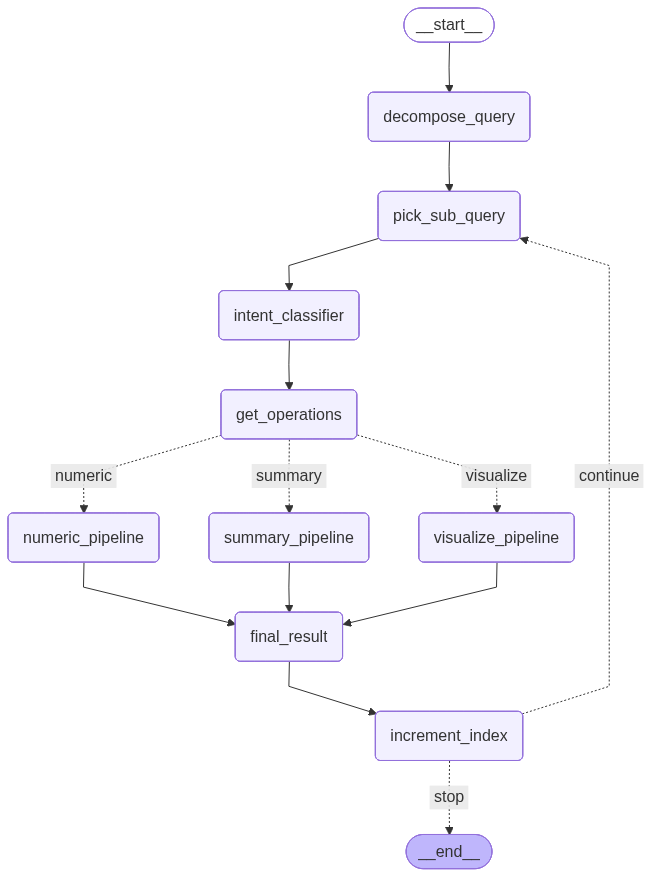

In [2]:
# Visualize the Graph
from langgraph.graph import StateGraph, START, END
from typing import TypedDict, Optional, Dict, Any, List
from IPython.display import Image

class GraphState(TypedDict):
    question: str
    sub_queries: Optional[List[str]]
    current_sub_query: Optional[str]
    current_index: Optional[int]
    results: Optional[List[Dict[str, Any]]]
    intent: Optional[int]
    operation: Optional[str]
    params: Dict[str, Any]
    numeric_result: Optional[Any]
    documents: Optional[List[str]]
    summary_result: Optional[str]
    final_answer: Optional[str]

graph = StateGraph(GraphState)

# -------- Nodes --------
graph.add_node("decompose_query", lambda x: x)
graph.add_node("pick_sub_query", lambda x: x)
graph.add_node("intent_classifier", lambda x: x)
graph.add_node("get_operations", lambda x: x)
graph.add_node("numeric_pipeline", lambda x: x)
graph.add_node("summary_pipeline", lambda x: x)
graph.add_node("final_result", lambda x: x)
graph.add_node("increment_index", lambda x: x)
graph.add_node("visualize_pipeline",lambda X: x)

def should_continue(**kwargs):
    pass

#

graph.add_edge(START, "decompose_query")
graph.add_edge("decompose_query", "pick_sub_query")
graph.add_edge("pick_sub_query", "intent_classifier")

# Intent routing
graph.add_edge("intent_classifier", "get_operations")

graph.add_conditional_edges(
    "get_operations",
    lambda state: state["intent"],
    {
        "numeric": "numeric_pipeline",
        "visualize": "visualize_pipeline",
        "summary": "summary_pipeline"
    }
)



# Numeric path
graph.add_edge("numeric_pipeline", "final_result")

# Summary path
graph.add_edge("summary_pipeline", "final_result")
graph.add_edge("visualize_pipeline", "final_result")

graph.add_edge("final_result","increment_index")

# Loop control (NO should_continue node)
graph.add_conditional_edges(
    "increment_index",
    should_continue,   # decision function ONLY
    {
        "continue": "pick_sub_query",
        "stop": END
    }
)

final_graph = graph.compile()

# Generate the graph visualization
graph_image = final_graph.get_graph().draw_mermaid_png()
Image(graph_image)